In [1]:
#Importing Libs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB


np.random.seed(0) #Setting the seed globally since sklearn uses numpy https://www.mikulskibartosz.name/how-to-set-the-global-random_state-in-scikit-learn/

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\M\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\M\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\M\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\M\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## importing the dataset and exploring

There're three columns, body, title, and category (which we're trying to classify).  
We also see there is 2481 records and none have empty values.

In [2]:
df = pd.read_json("articles.json")
df.tail()

,body,title,category
2476,"At the Early Stage, Focus on Unit Economic Pro...","At the Early Stage, Focus on Unit Economic Pro...",Startups & Business
2477,5 Tips to Nail a Successful Product Launch\n\n...,5 Tips to Nail a Successful Product Launch,Startups & Business
2478,Routes to Defensibility for your AI Startup\n\...,Routes to Defensibility for your AI Startup,Engineering
2479,Faster. Faster. Faster.\r\n\r\nI’d like to tal...,Faster. Faster. Faster.,Product & Design
2480,Netflix is a place where people win. They exce...,Humans Hate Being Spun: How to Practice Radica...,Startups & Business


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2481 entries, 0 to 2480
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   body      2481 non-null   object
 1   title     2481 non-null   object
 2   category  2481 non-null   object
dtypes: object(3)
memory usage: 58.3+ KB
None


In [4]:
df["body"][0]

'Protecting Netflix Viewing Privacy at Scale\r\n\r\nOn the Open Connect team at Netflix, we are always working to enhance the hardware and software in the purpose-built Open Connect Appliances (OCAs) that store and serve Netflix video content. As we mentioned in a recent company blog post, since the beginning of the Open Connect program we have significantly increased the efficiency of our OCAs — from delivering 8 Gbps of throughput from a single server in 2012 to over 90 Gbps from a single server in 2016. We contribute to this effort on the software side by optimizing every aspect of the software for our unique use case — in particular, focusing on the open source FreeBSD operating system and the NGINX web server that run on the OCAs.\r\n\r\nMembers of the team will be presenting a technical session on this topic at the Intel Developer Forum (IDF16) in San Francisco this month. This blog introduces some of the work we’ve done.\r\n\r\nAdding TLS to Video Streams\r\n\r\nIn the modern in

Looking at one of the articles, we see that we would need to normalize all to lower case and remove special characters and keep only alphanumerical ones.

### Cleaning up to prepare for the model.

Converting all text to lower case.

In [5]:
df['body_org'] = df['body']
df['title_org'] = df['title']
df['body'] = df['body'].str.lower()
df['title'] = df['title'].str.lower()

Checking for duplicates

In [6]:
print(df.duplicated(subset=['title']).sum())
print(df.duplicated(subset=['body']).sum())

29
101


In [7]:
df[df.duplicated(subset=['body'],keep=False)].sort_values(by="body")

,body,title,category,body_org,title_org
1878,,practical marketing tips for saas businesses,Startups & Business,,Practical Marketing Tips for SAAS Businesses
695,,"introducing ohana, uber engineering’s ios cont...",Engineering,,"Introducing Ohana, Uber Engineering’s iOS Cont..."
1947,,what most billion-dollar startups have in common,Startups & Business,,What Most Billion-Dollar Startups Have in Common
744,,how long will it take for my startup to be suc...,Startups & Business,,How Long Will It Take For My Startup To Be Suc...
770,,what do i do now? the startup lifecycle,Startups & Business,,What Do I Do Now? The Startup Lifecycle
...,...,...,...,...,...
1265,why 2017 should be a great year to raise ventu...,why 2017 should be a great year to raise ventu...,Startups & Business,Why 2017 Should be a Great Year to Raise Ventu...,Why 2017 Should be a Great Year to Raise Ventu...
114,"written by weronika łabaj on april 07, 2016 · ...",confession: i don't think uber is actually a g...,Startups & Business,"Written by Weronika Łabaj on April 07, 2016 · ...",Confession: I Don't Think Uber is Actually a G...
1438,"written by weronika łabaj on april 07, 2016 · ...",five lessons from scaling pinterest,Startups & Business,"Written by Weronika Łabaj on April 07, 2016 · ...",Five Lessons from Scaling Pinterest
1790,“we were able to email 10 of our customer advi...,start up on the right foot — build a customer ...,Startups & Business,“We were able to email 10 of our customer advi...,Start Up on the Right Foot — Build a Customer ...


We notice that there are some empty body and also rows with indeces 1790 and 1812 have similar name but one have extra dash.
I'll remove nonalphanumericals and check the word count.

In [8]:
def keep_alphanum(body):
  reviews = ''
  for x in body:
    if x.isalnum():
      reviews = reviews + x
    else:
      reviews = reviews + ' '
  return reviews

df['body'] = df['body'].apply(keep_alphanum)
df['title'] = df['title'].apply(keep_alphanum)

In [9]:
print(df.duplicated(subset=['title']).sum())
print(df.duplicated(subset=['body']).sum())

37
101


we notice that duplicates in title went from 29 to 37 as noted previously.

In [10]:
#getting count of words in body
df["words"] = df['body'].str.split().str.len()

In [11]:
len(df[df.words == 0])

49

There are 49 rows with no text in body

In [12]:
df.drop_duplicates(subset=["body"], inplace=True)

In [13]:
df.describe(percentiles=[.01,.05,.25, .5, .75,.95,.99])

,words
count,2380.000000
mean,1692.239916
std,1492.752693
min,0.000000
1%,44.000000
5%,230.950000
25%,780.750000
50%,1311.000000
75%,2089.750000
95%,4268.000000


we notice that most articles have between 230 and 4270 words.
lets explore the ones that have less than 100

In [14]:
df[df.words <= 100].sort_values(by="words", ascending=False)

,body,title,category,body_org,title_org,words
83,self contained systems assembling software fro...,scs self contained systems,Engineering,Self-Contained Systems Assembling Software fro...,SCS: Self-Contained Systems,97
1389,the founder institute hosts webinars every mon...,the most common misconception among early stag...,Startups & Business,The Founder Institute hosts webinars every mon...,The Most Common Misconception Among Early-Stag...,96
1297,probabilistic modelling provides a mathematica...,strachey lecture probabilistic machine learn...,Engineering,Probabilistic modelling provides a mathematica...,Strachey Lecture - Probabilistic machine learn...,95
541,published on oct 25 2011 speaker s profess...,good strategy bad strategy the difference and...,Startups & Business,"Published on Oct 25, 2011\n\nSpeaker(s): Profe...",Good Strategy/Bad Strategy: the difference and...,94
562,over the last 3 years i ve worked as a ux des...,50 things i learned from spending 3 years as a...,Product & Design,"Over the last 3 years, I’ve worked as a UX des...",50 things I learned from spending 3 years as a...,91
1320,there is no one right way to build a company...,can you launch a company with passion alone,Startups & Business,"There is no ""one right way"" to build a company...",Can You Launch a Company With Passion Alone?,89
324,تم نشره في 08 08 2016 this presentation was...,goto 2016 from monolith to microservices at ...,Engineering,تم نشره في 08‏/08‏/2016\n\nThis presentation w...,GOTO 2016 • From Monolith to Microservices at ...,88
987,please click i am not a robot to continue a...,apply this simple thought exercise before crea...,Startups & Business,"Please click ""I am not a robot"" to continue\n\...",Apply This Simple Thought Exercise Before Crea...,83
423,please click i am not a robot to continue ...,how one startup focused on the long tail to dr...,Startups & Business,"Please click ""I am not a robot"" to continue\r\...",How One Startup Focused On The Long Tail To Dr...,83
1701,please click i am not a robot to continue a...,everything you ve ever wanted to know about vc...,Startups & Business,"Please click ""I am not a robot"" to continue\n\...",Everything You've Ever Wanted To Know About VC...,83


Seems like some of them are due to errors during scraping, like:  
`please click i am not a robot to continue`  
or `javascript is currently disabled in`  
I'll remove the ones less than 200 words.


In [15]:
df = df[df.words >= 200]
df.describe(percentiles=[.01,.05,.25, .5, .75,.95,.98,.99])

,words
count,2280.000000
mean,1762.273684
std,1486.327426
min,202.000000
1%,237.790000
5%,396.900000
25%,859.750000
50%,1350.000000
75%,2158.250000
95%,4287.000000


We will remove stop words as explained earlier, we can see a few even on the first line.

In [16]:
def remove_stopwords(body):
  stop_words = set(stopwords.words('english'))
  words = word_tokenize(body)
  return [x for x in words if x not in stop_words]

df['body'] = df['body'].apply(remove_stopwords)

we will factorize the categories (add a numberical id for each category).

In [17]:
target_category = df['category'].unique()
df['categoryId'] = df['category'].factorize()[0]
df.tail()

,body,title,category,body_org,title_org,words,categoryId
2475,"[true, personalization, popular, always, answe...",why personalization is dead and what to do in...,Startups & Business,"It’s true: personalization is popular.\n\nBut,...",Why Personalization is Dead (And What to Do In...,2335,1
2476,"[early, stage, focus, unit, economic, profitab...",at the early stage focus on unit economic pro...,Startups & Business,"At the Early Stage, Focus on Unit Economic Pro...","At the Early Stage, Focus on Unit Economic Pro...",1265,1
2477,"[5, tips, nail, successful, product, launch, p...",5 tips to nail a successful product launch,Startups & Business,5 Tips to Nail a Successful Product Launch\n\n...,5 Tips to Nail a Successful Product Launch,1602,1
2478,"[routes, defensibility, ai, startup, simple, f...",routes to defensibility for your ai startup,Engineering,Routes to Defensibility for your AI Startup\n\...,Routes to Defensibility for your AI Startup,2645,0
2479,"[faster, faster, faster, like, talk, fast, lef...",faster faster faster,Product & Design,Faster. Faster. Faster.\r\n\r\nI’d like to tal...,Faster. Faster. Faster.,873,2


There are three categories in this df.

In [18]:
category = df[['category', 'categoryId']].drop_duplicates().sort_values('categoryId')
category

,category,categoryId
0,Engineering,0
7,Startups & Business,1
57,Product & Design,2


Looking at the distribtution of the values, Startups & Business	is the most common, with Engineering being the least common.

In [19]:
df['category'].value_counts()

Startups & Business    967
Product & Design       809
Engineering            504
Name: category, dtype: int64

Splitting the dataset, we will be using the body column for training our models.

In [20]:
body = df["body"]
category = df['category']

we will use NLTK lib for stemming/lemmatization (converting words to their root (lemma), for example cars to car)

In [21]:
def lemmatize_word(body):
  wordnet = WordNetLemmatizer()
  return " ".join([wordnet.lemmatize(word) for word in body])
df['body'] = df['body'].apply(lemmatize_word)

In [22]:
df.tail()

,body,title,category,body_org,title_org,words,categoryId
2475,true personalization popular always answer tri...,why personalization is dead and what to do in...,Startups & Business,"It’s true: personalization is popular.\n\nBut,...",Why Personalization is Dead (And What to Do In...,2335,1
2476,early stage focus unit economic profitability ...,at the early stage focus on unit economic pro...,Startups & Business,"At the Early Stage, Focus on Unit Economic Pro...","At the Early Stage, Focus on Unit Economic Pro...",1265,1
2477,5 tip nail successful product launch past two ...,5 tips to nail a successful product launch,Startups & Business,5 Tips to Nail a Successful Product Launch\n\n...,5 Tips to Nail a Successful Product Launch,1602,1
2478,route defensibility ai startup simple framewor...,routes to defensibility for your ai startup,Engineering,Routes to Defensibility for your AI Startup\n\...,Routes to Defensibility for your AI Startup,2645,0
2479,faster faster faster like talk fast left build...,faster faster faster,Product & Design,Faster. Faster. Faster.\r\n\r\nI’d like to tal...,Faster. Faster. Faster.,873,2


splitting the df to prepare for model, x is the body of article, the training column and y is the category, what we're trying to predict.

In [23]:
x = df['body']
y = df['categoryId']

### Preparing models

we will use a scikit-learn function to vectorize our words (convert words to the count of which they're appearing in said article).  
I'll be seeing the max features parameter to limit the words to take into consideration into the most frequent words, so the models don't take long.  
according to research, with only knowing 800 lammas, you can understand 75% of the language.  
you need about 8000 (which is more than 99% of the articles here) lemmas to get around well written newspapers, so I'll be sitting it for half of that at **4000** for speed.  
Source: https://www.bbc.com/news/world-44569277

In [24]:
x = np.array(df.iloc[:,0].values)
y = np.array(df.categoryId.values)
cv = CountVectorizer(max_features = 8000)
x = cv.fit_transform(df.body).toarray()
print("X.shape = ",x.shape)
print("y.shape = ",y.shape)

X.shape =  (2280, 8000)
y.shape =  (2280,)


we will split our df into a training and a test parts, using 30% for test and 70% training.  

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.7, random_state = 0)

print(len(x_train))
print(len(x_test))

1596
684


I'll create a function to try different models and then output the scores of these models into a pandas dataframe for comparison.

In [26]:
#create list of model and their performance
perform_list = []

def try_model(model_name):
    mdl=''
    if model_name == 'Logistic Regression':
        mdl = LogisticRegression(max_iter=500) #increasing iterations since default 100 wasn't enough
    elif model_name == 'Random Forest':
        mdl = RandomForestClassifier()
    elif model_name == 'Multinomial Naive Bayes':
        mdl = MultinomialNB()
    elif model_name == 'Decision Tree Classifier':
        mdl = DecisionTreeClassifier()
    elif model_name == 'K Nearest Neighbour':
        mdl = KNeighborsClassifier()
    elif model_name == 'Gaussian Naive Bayes':
        mdl = GaussianNB()
   


    oneVsRest = OneVsRestClassifier(mdl)
    oneVsRest.fit(x_train, y_train)
    y_pred = oneVsRest.predict(x_test)
    
    
    # Performance metrics
    accuracy = round(accuracy_score(y_test, y_pred) * 100, 4)
    # Get the weighted precision, recall, f1 scores
    precision, recall, f1score, support = score(y_test, y_pred, average='weighted')

    print(f'Test Accuracy Score of Basic {model_name}: % {accuracy}')
    print(f'Precision : {precision}')
    print(f'Recall    : {recall}')
    print(f'F1-score   : {f1score}')

    # Add performance parameters to list
    perform_list.append(dict([
        ('Model', model_name),
        ('Test Accuracy', round(accuracy, 4)),
        ('Precision', round(precision, 4)),
        ('Recall', round(recall, 4)),
        ('F1', round(f1score, 4))
         ]))


In [27]:
for mod_n in ['Logistic Regression', 
'Random Forest', 
'Multinomial Naive Bayes', 
'Decision Tree Classifier', 
'K Nearest Neighbour', 
'Gaussian Naive Bayes']: 
    try_model(mod_n)

Test Accuracy Score of Basic Logistic Regression: % 83.7719
Precision : 0.8418543928519849
Recall    : 0.8377192982456141
F1-score   : 0.8388729251072357
Test Accuracy Score of Basic Random Forest: % 85.0877
Precision : 0.8540231462440668
Recall    : 0.8508771929824561
F1-score   : 0.8512340979029853
Test Accuracy Score of Basic Multinomial Naive Bayes: % 83.4795
Precision : 0.8516542278688471
Recall    : 0.8347953216374269
F1-score   : 0.8362687884157204
Test Accuracy Score of Basic Decision Tree Classifier: % 67.8363
Precision : 0.7598843463037166
Recall    : 0.6783625730994152
F1-score   : 0.6834166627785949
Test Accuracy Score of Basic K Nearest Neighbour: % 74.5614
Precision : 0.7832181536580224
Recall    : 0.7456140350877193
F1-score   : 0.7440639287613273
Test Accuracy Score of Basic Gaussian Naive Bayes: % 65.6433
Precision : 0.721733528708094
Recall    : 0.6564327485380117
F1-score   : 0.6616302330310546


We find that the Random Forest model is giving the best results, so we will go with that one.

In [28]:
model_performance = pd.DataFrame(data=perform_list)
model_performance = model_performance[['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
model_performance

,Model,Test Accuracy,Precision,Recall,F1
0,Logistic Regression,83.7719,0.8419,0.8377,0.8389
1,Random Forest,85.0877,0.8540,0.8509,0.8512
2,Multinomial Naive Bayes,83.4795,0.8517,0.8348,0.8363
3,Decision Tree Classifier,67.8363,0.7599,0.6784,0.6834
4,K Nearest Neighbour,74.5614,0.7832,0.7456,0.7441
5,Gaussian Naive Bayes,65.6433,0.7217,0.6564,0.6616


In [29]:
row = model_performance.iloc[model_performance['Test Accuracy'].idxmax()]
max_value = row['Test Accuracy']
max_model = row['Model']
print("The model with the most accuracy is {} at {}%".format(max_model, max_value))

The model with the most accuracy is Random Forest at 85.0877%


#### Cross Validation and Parameter optimizing for Random Forest.

I'll use GridSearchCV from science kit to perform cross validation and check for a better optimized model

I'll be keeping the defaults for the RandomForestClassifier() as is, but will change the number of estimators to see which is best.  
Keeping defaults means max_depth= None which is unlimited, at the cost of performance

In [30]:
forest = RandomForestClassifier(random_state = 0, n_estimators = 100)
forest.fit(x_train,y_train)
y_pred_best = forest.predict(x_test)

print(accuracy_score(y_test , y_pred_best))

0.8333333333333334


In [31]:
from sklearn.model_selection import GridSearchCV

rfc=RandomForestClassifier(random_state=0)

param_grid = { 
    'n_estimators': [100, 200, 400, 700, 1000]
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= None)
CV_rfc.fit(x_train, y_train)
CV_rfc.best_params_

{'n_estimators': 1000}

In [32]:
forest = RandomForestClassifier(random_state = 0, n_estimators = 100)
forest.fit(x_train,y_train)
y_pred_best = forest.predict(x_test)

print(accuracy_score(y_test , y_pred_best))
print(classification_report(y_pred_best, y_test, target_names=target_category))

0.8333333333333334
                     precision    recall  f1-score   support

        Engineering       0.86      0.98      0.91       145
Startups & Business       0.87      0.81      0.84       328
   Product & Design       0.76      0.77      0.77       211

           accuracy                           0.83       684
          macro avg       0.83      0.85      0.84       684
       weighted avg       0.83      0.83      0.83       684



We see that with more estimators the accuracy barely by less than 1%, but for 7 times the time needs, I think staying with the default 100 is best.  

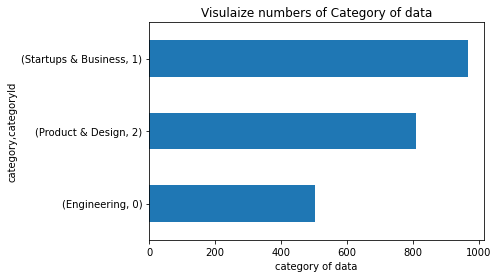

In [33]:
df.groupby('category').categoryId.value_counts().plot(kind = "barh")
plt.xlabel("category of data")
plt.title("Visulaize numbers of Category of data")
plt.show()

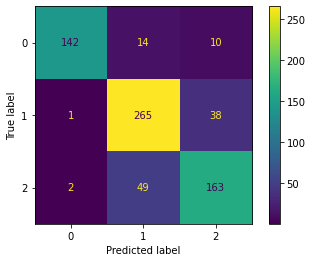

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_best)).plot()

We can see from the confusion matrix that the most wrong prediction are between category 1 (Business) and 2  (Product), which makes sense given that they both have most values and probably a lot of overlap in terms used.

We will use a popular visual called word cloud to look at the popular words for each category of articles.

In [35]:
#Getting a dataframe for each category

business = df[df['categoryId'] == 1]

business = business['body']

product = df[df['categoryId'] == 2]

product = product['body']

eng = df[df['categoryId'] == 0]

eng = eng['body']

In [36]:
# we will use NLTK lib to remove stop words (words that are common in English without effect on context, like "the" or "an")

stop = set(stopwords.words('english'))

def wordcloud_draw(df, color = 'white'):
    words = ' '.join(df)
    cleaned_word = ' '.join([word for word in words.split()])
    wordcloud = WordCloud(stopwords = stop,
    background_color = color,
    width = 2500, height = 2500).generate(cleaned_word)
    
    plt.figure(1, figsize = (10,7))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

print("Words common in business articles:")
#wordcloud_draw(business, 'white')

print("Words commoon in product articles:")
#wordcloud_draw(product, 'white')

print("Words common in engineering articles:")
#wordcloud_draw(eng, 'white')

Words common in business articles:
Words commoon in product articles:
Words common in engineering articles:


#### Conclusion
We can see that there is a lot of of overlap between the three categories, like "Team", "User", and "Product".  
Which makes sense given that engineering makes products for businesses (the three categories we have).

#### Clustering

We now will do the clustering part, for reference: https://towardsdatascience.com/k-means-clustering-with-scikit-learn-6b47a369a83c

Repeating the features as earlier, but doing only engineering

In [37]:
df = df[df.category == 'Engineering']

x = df['body']
y = df['categoryId']

x = np.array(df.iloc[:,0].values)
y = np.array(df.categoryId.values)
cv = CountVectorizer(max_features = 8000)
x = cv.fit_transform(df.body).toarray()
print("X.shape = ",x.shape)
print("y.shape = ",y.shape)

X.shape =  (504, 8000)
y.shape =  (504,)


In [38]:
silhouette = []
test_count = np.arange(2, 31)

for k in test_count:
    kmeans = KMeans(k, random_state=0)
    model = kmeans.fit(x)
    preds = model.predict(x)
    sil_score = silhouette_score(x, preds)
    score = np.abs(model.score(x))
    silhouette.append(sil_score)

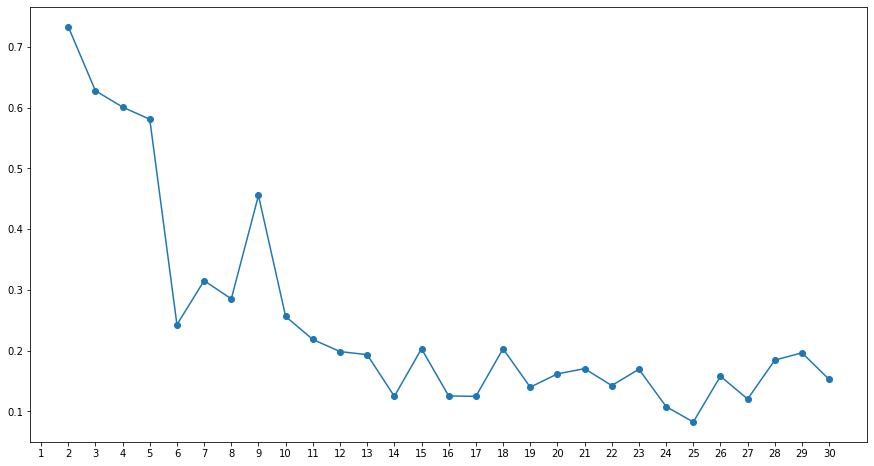

In [39]:
plt.figure(figsize=(15, 8))
plt.xticks(np.arange(0, test_count[-1]+1, step=1))
plt.plot(test_count, silhouette, linestyle='-', marker='o');

Seems the optimal number is two clusters, but will use four as mentioned in the project description

In [40]:
kmeans_n = KMeans(n_clusters=4, random_state=0)
model_eng = kmeans_n.fit(x)
clusters_eng = model_eng.predict(x)

In [41]:
(unique, counts) = np.unique(clusters_eng, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[  0   1]
 [  1  12]
 [  2   1]
 [  3 490]]


As we see here, most (490 articles) fall into cluster 3, with barely any clusters in the other groups (only 14), so 2 clusters should been optimal.

In [42]:
df["Cluster"] = clusters_eng

In [43]:
jsondf = df[["body_org", "title_org", "Cluster"]]
jsondf.to_json("eng_clusters.json", orient="table")